In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from econml.grf import CausalForest

from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("bsc_project_set.csv", index_col=0)
print(data.shape)
print(data.columns)
data

(3941, 27)
Index(['id', 'mort_28', 'age', 'sex', 'weight', 'height', 'pf_ratio', 'po2',
       'pco2', 'ph', 'driving_pressure', 'lung_compliance', 'map', 'bilirubin',
       'creatinine', 'platelets', 'urea', 'fio2', 'hco3', 'heart_rate',
       'minute_volume', 'peep', 'plateau_pressure', 'respiratory_rate',
       'syst_blood_pressure', 'diastolic_blood_pressure', 'peep_regime'],
      dtype='object')


,id,mort_28,age,sex,weight,height,pf_ratio,po2,pco2,ph,...,fio2,hco3,heart_rate,minute_volume,peep,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,peep_regime
0,32128372,False,75,F,93.0,168.0,241.944444,130.666667,28.111111,7.245556,...,50.000000,12.000000,115.408163,8.241111,8.777778,24.333333,18.943662,100.600000,68.200000,low
1,34100191,False,47,M,127.0,183.0,166.356061,113.076923,34.461538,7.196923,...,68.500000,12.750000,115.407407,16.628571,7.375000,17.500000,19.857143,99.000000,68.000000,low
2,38292466,False,85,M,77.5,170.0,224.000000,112.000000,38.000000,7.440000,...,51.818182,23.000000,70.041667,9.433333,5.000000,22.333333,15.833333,102.000000,46.333333,low
3,32743332,False,85,M,90.7,170.0,205.714286,72.000000,38.000000,7.500000,...,36.875000,27.000000,70.480000,7.478571,5.000000,24.000000,18.200000,108.083333,46.208333,low
4,35009126,True,64,M,70.0,183.0,173.777778,94.666667,38.666667,7.400000,...,52.500000,21.666667,73.955556,7.050000,5.428571,14.328571,15.016667,103.415094,57.377358,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,32959861,True,78,F,57.0,160.0,157.178571,136.833333,38.083333,7.370833,...,65.454545,22.000000,95.785714,8.511111,6.800000,22.000000,16.677419,NaN,NaN,low
3937,32761676,False,75,M,101.0,178.0,179.909091,91.714286,39.000000,7.310000,...,52.142857,17.600000,60.394737,7.250000,5.000000,15.400000,16.795455,NaN,NaN,low
3938,34058245,True,67,F,100.0,165.0,158.331733,104.250000,43.250000,7.292500,...,77.142857,18.800000,122.041667,8.813333,16.700000,30.333333,25.290323,101.789474,59.631579,high
3939,34670930,False,68,M,94.7,163.0,192.500000,90.600000,40.400000,7.414000,...,60.000000,23.500000,65.807692,8.816667,9.166667,21.285714,21.531250,158.000000,83.500000,low


In [3]:
xs = data.copy()

y = xs["mort_28"]
w = xs["peep_regime"]

w = pd.Series(map(lambda x: 0 if x == "low" else 1, w))
y = pd.Series(map(lambda x: 0 if x == False else 1, y))

xs = xs.drop(columns=["id", "mort_28", "peep", "peep_regime"])
columns_x = xs.columns

xs.loc[xs["sex"] == "M", "sex"] = 0
xs.loc[xs["sex"] == "F", "sex"] = 1

xs

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
0,75,1,93.0,168.0,241.944444,130.666667,28.111111,7.245556,11.000000,31.227273,...,83.000000,3.71280,50.000000,12.000000,115.408163,8.241111,24.333333,18.943662,100.600000,68.200000
1,47,0,127.0,183.0,166.356061,113.076923,34.461538,7.196923,8.350000,79.780702,...,19.600000,32.21925,68.500000,12.750000,115.407407,16.628571,17.500000,19.857143,99.000000,68.000000
2,85,0,77.5,170.0,224.000000,112.000000,38.000000,7.440000,17.250000,33.338235,...,124.500000,16.42200,51.818182,23.000000,70.041667,9.433333,22.333333,15.833333,102.000000,46.333333
3,85,0,90.7,170.0,205.714286,72.000000,38.000000,7.500000,17.000000,26.882353,...,200.000000,24.63300,36.875000,27.000000,70.480000,7.478571,24.000000,18.200000,108.083333,46.208333
4,64,0,70.0,183.0,173.777778,94.666667,38.666667,7.400000,8.585714,52.821226,...,513.666667,5.11700,52.500000,21.666667,73.955556,7.050000,14.328571,15.016667,103.415094,57.377358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,78,1,57.0,160.0,157.178571,136.833333,38.083333,7.370833,16.400000,26.829268,...,209.666667,14.63700,65.454545,22.000000,95.785714,8.511111,22.000000,16.677419,NaN,NaN
3937,75,0,101.0,178.0,179.909091,91.714286,39.000000,7.310000,10.400000,42.412137,...,78.200000,28.70280,52.142857,17.600000,60.394737,7.250000,15.400000,16.795455,NaN,NaN
3938,67,1,100.0,165.0,158.331733,104.250000,43.250000,7.292500,13.200000,25.796667,...,309.400000,15.06540,77.142857,18.800000,122.041667,8.813333,30.333333,25.290323,101.789474,59.631579
3939,68,0,94.7,163.0,192.500000,90.600000,40.400000,7.414000,12.500000,33.805421,...,151.200000,6.69375,60.000000,23.500000,65.807692,8.816667,21.285714,21.531250,158.000000,83.500000


In [4]:
xs.describe()

,age,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,map,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
count,3941.000000,3939.000000,3374.000000,3610.000000,3792.000000,3794.000000,3794.000000,3279.000000,3259.000000,3237.000000,...,3924.000000,3936.000000,3859.000000,3935.000000,3941.000000,3741.000000,3608.000000,3941.000000,3241.000000,3239.000000
mean,63.191322,87.955657,169.400759,245.209237,133.270432,41.917010,7.345282,12.241982,42.172437,74.684663,...,197.416450,10.837012,57.893765,22.028731,89.136033,9.516279,20.698614,20.693890,112.103027,62.615542
std,16.110703,27.438546,11.347380,123.787407,52.375877,9.704451,0.081361,3.409175,18.840383,12.040751,...,109.101730,7.937028,13.975565,5.154144,17.818686,2.345188,5.153424,4.202464,17.031672,12.019379
min,18.000000,20.000000,64.000000,26.000000,25.000000,16.444444,6.999231,0.000000,5.726872,28.500000,...,8.000000,0.357000,10.000000,8.000000,45.012195,1.275000,0.000000,4.142857,49.000000,23.250000
25%,53.000000,69.400000,163.000000,160.000000,95.500000,35.750000,7.294325,10.000000,31.524536,67.000000,...,122.468750,5.622750,48.125000,18.666667,76.153846,7.883333,17.000000,17.628571,101.000000,54.671171
50%,65.000000,84.000000,170.000000,225.559524,121.071429,40.250000,7.347361,12.000000,39.155213,73.160000,...,178.690476,8.389500,55.555556,21.750000,87.625000,9.240000,20.200000,20.181818,109.350000,61.600000
75%,75.000000,101.700000,178.000000,302.500000,159.287582,45.854396,7.400000,14.200000,48.711688,81.000000,...,247.233333,13.494600,66.250000,25.000000,101.416667,10.887500,23.800000,23.357143,121.083333,69.020000
max,98.000000,296.800000,203.000000,1660.000000,472.000000,112.000000,7.700000,50.250000,314.500000,142.000000,...,1144.500000,70.839000,100.000000,47.000000,161.441860,25.475000,115.000000,37.500000,189.888889,132.000000


In [5]:
norm_xs = (xs - xs.mean())/xs.std()
norm_xs

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
0,0.732971,1.191182,0.183841,-0.123443,-0.026374,-0.049713,-1.422636,-1.225725,-0.364306,-0.580942,...,-1.048713,-0.897592,-0.564826,-1.945761,1.474415,-0.543738,0.705302,-0.416477,-0.67539,0.464621
1,-1.005004,-0.839289,1.422974,1.198448,-0.637005,-0.38555,-0.768253,-1.823462,-1.14162,1.996152,...,-1.629822,2.693985,0.758913,-1.800247,1.474372,3.032717,-0.620678,-0.199109,-0.769333,0.447981
2,1.353676,-0.839289,-0.381057,0.052809,-0.171336,-0.406111,-0.40363,1.164175,1.468983,-0.468897,...,-0.668334,0.703662,-0.434729,0.188444,-1.071592,-0.035368,0.31721,-1.156597,-0.593191,-1.354663
3,1.353676,-0.839289,0.100018,0.052809,-0.319055,-1.169822,-0.40363,1.901629,1.395651,-0.811559,...,0.02368,1.738181,-1.503965,0.964519,-1.046993,-0.868889,0.64062,-0.593435,-0.236013,-1.365063
4,0.050195,-0.839289,-0.654395,1.198448,-0.577049,-0.737052,-0.334933,0.672538,-1.072479,0.565211,...,2.898673,-0.720674,-0.385943,-0.070247,-0.851941,-1.051634,-1.23608,-1.350927,-0.510105,-0.435811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,0.919183,1.191182,-1.128181,-0.828452,-0.711144,0.068026,-0.395043,0.314053,1.219655,-0.814377,...,0.112283,0.478767,0.541,-0.005574,0.373186,-0.428608,0.252528,-0.955742,NaN,NaN
3937,0.732971,-0.839289,0.475402,0.757817,-0.527518,-0.793421,-0.300585,-0.433644,-0.540301,0.012723,...,-1.092709,2.250942,-0.411497,-0.859256,-1.612986,-0.966353,-1.028174,-0.927655,NaN,NaN
3938,0.236407,1.191182,0.438957,-0.387822,-0.701828,-0.55408,0.137359,-0.648735,0.281012,-0.869185,...,1.026414,0.532742,1.377339,-0.626434,1.846693,-0.299739,1.869576,1.093747,-0.605551,-0.248263
3939,0.298477,-0.839289,0.245798,-0.564074,-0.425805,-0.814696,-0.156321,0.844611,0.075683,-0.4441,...,-0.423609,-0.522017,0.150708,0.285454,-1.309207,-0.298318,0.113924,0.199255,2.694801,1.737565


In [6]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imp_xs = imputer.fit_transform(norm_xs)

imp_xs = pd.DataFrame(data=imp_xs, columns=columns_x)

imp_xs

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,platelets,urea,fio2,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure
0,0.732971,1.191182,0.183841,-0.123443,-0.026374,-0.049713,-1.422636,-1.225725,-0.364306,-0.580942,...,-1.048713,-0.897592,-0.564826,-1.945761,1.474415,-0.543738,0.705302,-0.416477,-0.675390,0.464621
1,-1.005004,-0.839289,1.422974,1.198448,-0.637005,-0.385550,-0.768253,-1.823462,-1.141620,1.996152,...,-1.629822,2.693985,0.758913,-1.800247,1.474372,3.032717,-0.620678,-0.199109,-0.769333,0.447981
2,1.353676,-0.839289,-0.381057,0.052809,-0.171336,-0.406111,-0.403630,1.164175,1.468983,-0.468897,...,-0.668334,0.703662,-0.434729,0.188444,-1.071592,-0.035368,0.317210,-1.156597,-0.593191,-1.354663
3,1.353676,-0.839289,0.100018,0.052809,-0.319055,-1.169822,-0.403630,1.901629,1.395651,-0.811559,...,0.023680,1.738181,-1.503965,0.964519,-1.046993,-0.868889,0.640620,-0.593435,-0.236013,-1.365063
4,0.050195,-0.839289,-0.654395,1.198448,-0.577049,-0.737052,-0.334933,0.672538,-1.072479,0.565211,...,2.898673,-0.720674,-0.385943,-0.070247,-0.851941,-1.051634,-1.236080,-1.350927,-0.510105,-0.435811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,0.919183,1.191182,-1.128181,-0.828452,-0.711144,0.068026,-0.395043,0.314053,1.219655,-0.814377,...,0.112283,0.478767,0.541000,-0.005574,0.373186,-0.428608,0.252528,-0.955742,-0.205677,-0.683525
3937,0.732971,-0.839289,0.475402,0.757817,-0.527518,-0.793421,-0.300585,-0.433644,-0.540301,0.012723,...,-1.092709,2.250942,-0.411497,-0.859256,-1.612986,-0.966353,-1.028174,-0.927655,-0.702715,-0.705604
3938,0.236407,1.191182,0.438957,-0.387822,-0.701828,-0.554080,0.137359,-0.648735,0.281012,-0.869185,...,1.026414,0.532742,1.377339,-0.626434,1.846693,-0.299739,1.869576,1.093747,-0.605551,-0.248263
3939,0.298477,-0.839289,0.245798,-0.564074,-0.425805,-0.814696,-0.156321,0.844611,0.075683,-0.444100,...,-0.423609,-0.522017,0.150708,0.285454,-1.309207,-0.298318,0.113924,0.199255,2.694801,1.737565


In [7]:
y

0       0
1       0
2       0
3       0
4       1
       ..
3936    1
3937    0
3938    1
3939    0
3940    1
Length: 3941, dtype: int64

In [8]:
w

0       0
1       0
2       0
3       0
4       0
       ..
3936    0
3937    0
3938    1
3939    0
3940    0
Length: 3941, dtype: int64

In [9]:
full_data = imp_xs.assign(W=w, Y=y)

causal_forest = CausalForest()
causal_forest.fit(full_data[columns_x], full_data["W"], full_data["Y"])
data_with_cate = full_data.assign(cate=causal_forest.predict(full_data[columns_x]))

In [12]:
data_with_cate["cate"].describe()

count    3941.000000
mean        0.124016
std         0.091110
min        -0.155703
25%         0.058088
50%         0.117032
75%         0.184218
max         0.471382
Name: cate, dtype: float64

In [7]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

In [8]:
full_data = imp_xs.assign(W=w, Y=y)

# train_x, test_x, train_w, test_w, train_y, test_y = train_test_split(imp_xs, w, y, test_size=0.3)
train, test = train_test_split(full_data, test_size=0.3)

invalid value encountered in scalar divide


Text(0.5, 1.0, 'Cumulative gain curve - Causal forest')

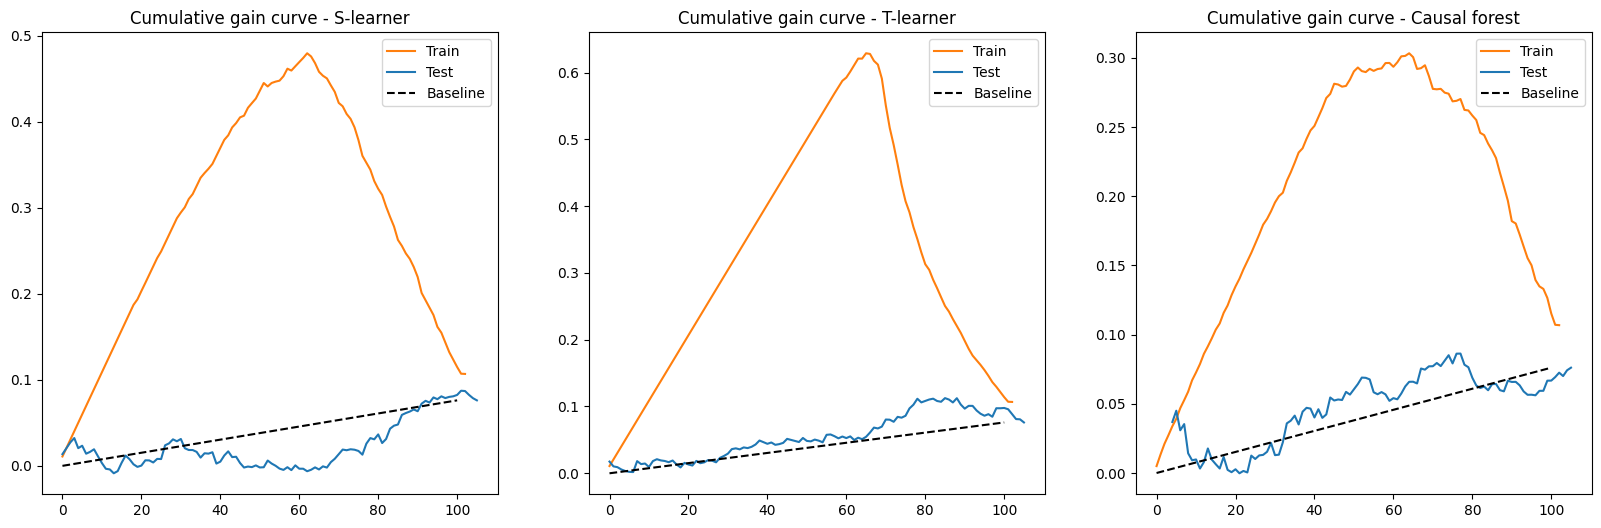

In [9]:
train_x = train[columns_x]
test_x = test[columns_x]

# S-learner
regr_s = RandomForestRegressor()
regr_s.fit(train.drop(columns=["Y"]), train["Y"])

# T-learner
regr0_t = RandomForestRegressor()
regr1_t = RandomForestRegressor()
regr0_t.fit(train.query("W==0").drop(columns=["W", "Y"]), train.query("W==0")["Y"])
regr1_t.fit(train.query("W==1").drop(columns=["W", "Y"]), train.query("W==1")["Y"])

# Causal forest
cau_forest = CausalForest()
cau_forest.fit(train_x, train["W"], train["Y"])

# GET CATE

s_learner_cate_train = train.assign(cate=regr_s.predict(train_x.assign(**{"W": 1})) - regr_s.predict(train_x.assign(**{"W": 0})))
s_learner_cate_test = test.assign(cate=regr_s.predict(test_x.assign(**{"W": 1})) - regr_s.predict(test_x.assign(**{"W": 0})))

t_learner_cate_train = train.assign(cate=regr1_t.predict(train_x) - regr0_t.predict(train_x))
t_learner_cate_test = test.assign(cate=regr1_t.predict(test_x) - regr0_t.predict(test_x))

causal_forest_cate_train = train.assign(cate=cau_forest.predict(train_x))
causal_forest_cate_test = test.assign(cate=cau_forest.predict(test_x))

# causal_forest_cate_train = train_x.assign(cate=cau_forest.predict(train_x), W=train_w, Y=train_y)
# causal_forest_cate_test = test_x.assign(cate=cau_forest.predict(test_x), W=test_w, Y=test_y)

# GET GAIN CURVES

gain_curve_train_s = cumulative_gain(s_learner_cate_train, "cate", y="Y", t="W")
gain_curve_test_s = cumulative_gain(s_learner_cate_test, "cate", y="Y", t="W")

gain_curve_train_t = cumulative_gain(t_learner_cate_train, "cate", y="Y", t="W")
gain_curve_test_t = cumulative_gain(t_learner_cate_test, "cate", y="Y", t="W")

gain_curve_train_c_f = cumulative_gain(causal_forest_cate_train, "cate", y="Y", t="W")
gain_curve_test_c_f = cumulative_gain(causal_forest_cate_test, "cate", y="Y", t="W")

# gain_curve_test = cumulative_gain(causal_forest_cate_test, "cate", y="Y", t="W")
# gain_curve_train = cumulative_gain(causal_forest_cate_train, "cate", y="Y", t="W")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

ax1.plot(gain_curve_train_s, color="C1", label="Train")
ax1.plot(gain_curve_test_s, color="C0", label="Test")
ax1.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
ax1.legend()
ax1.set_title("Cumulative gain curve - S-learner")

ax2.plot(gain_curve_train_t, color="C1", label="Train")
ax2.plot(gain_curve_test_t, color="C0", label="Test")
ax2.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
ax2.legend()
ax2.set_title("Cumulative gain curve - T-learner")

ax3.plot(gain_curve_train_c_f, color="C1", label="Train")
ax3.plot(gain_curve_test_c_f, color="C0", label="Test")
ax3.plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
ax3.legend()
ax3.set_title("Cumulative gain curve - Causal forest")
# plt.plot(gain_curve_test, color="C0", label="Test")
# plt.plot(gain_curve_train, color="C1", label="Train")
# plt.plot([0, 100], [0, elast(test_x.assign(W=test_w, Y=test_y), "Y", "W")], linestyle="--", color="black", label="Baseline")
# plt.legend()
# plt.title("Cumulative gain curve")
# plt.show()

In [17]:
causal_forest_cate_test

,age,sex,weight,height,pf_ratio,po2,pco2,ph,driving_pressure,lung_compliance,...,hco3,heart_rate,minute_volume,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,cate,W,Y
1791,0.236407,-0.839289,1.131414,0.757817,0.501188,0.441607,-0.218148,-0.556553,-0.315418,0.272703,...,-0.393612,-0.659850,0.693581,0.220187,-0.332766,0.369721,0.572780,0.146435,0,0
3523,-0.632581,-0.839289,-0.832976,1.198448,0.842499,0.654901,-0.786371,-0.047358,-1.009623,1.033699,...,-0.587630,-1.659191,0.456774,-1.183410,-0.056335,-1.148039,0.206704,0.090216,0,0
3654,-2.184344,-0.839289,1.240749,1.198448,0.375300,0.694905,-0.128842,1.082235,0.369010,0.055882,...,0.899846,0.372740,-0.226235,-0.426632,-0.774514,0.375593,0.731749,0.081876,0,0
2868,0.732971,1.191182,-0.545060,-0.564074,-0.005614,-0.144268,-0.359468,-0.082475,-0.334973,-0.021976,...,-0.587630,1.663041,-0.589695,-0.329609,-0.085796,1.760268,0.080519,0.023907,0,0
783,0.981253,1.191182,0.289532,-0.564074,0.117466,0.228723,-0.841574,-0.495098,-0.594078,0.033222,...,-0.510023,-0.383644,-0.497307,-0.006199,-0.444454,-1.356474,-0.883202,0.251330,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3894,1.291606,-0.839289,-1.674858,1.198448,-0.942147,-0.733870,1.124878,-0.884311,1.835640,-0.817808,...,0.091435,-0.498291,1.447404,0.612899,1.300475,-0.534476,0.170651,0.199187,0,1
1284,-2.494697,1.191182,-0.891288,0.317187,0.224504,0.726726,-0.128842,0.426720,0.711223,-0.559558,...,-0.199593,0.761429,-0.622792,-0.200245,-1.053949,-0.508381,0.096697,0.122134,0,0
636,-0.756722,-0.839289,2.567350,1.639078,-1.122190,-1.069585,1.245098,-0.126371,-0.667409,0.448526,...,0.964519,-0.237379,-0.073271,0.782920,-0.233102,0.073634,0.611408,0.015397,1,0
2561,0.919183,1.191182,0.573804,-1.401271,-1.024012,-0.934344,-0.758565,-0.447300,-0.657632,-0.098543,...,-1.053275,0.817172,0.590026,0.640620,0.243681,1.520519,-0.883202,0.231226,1,1


invalid value encountered in scalar divide


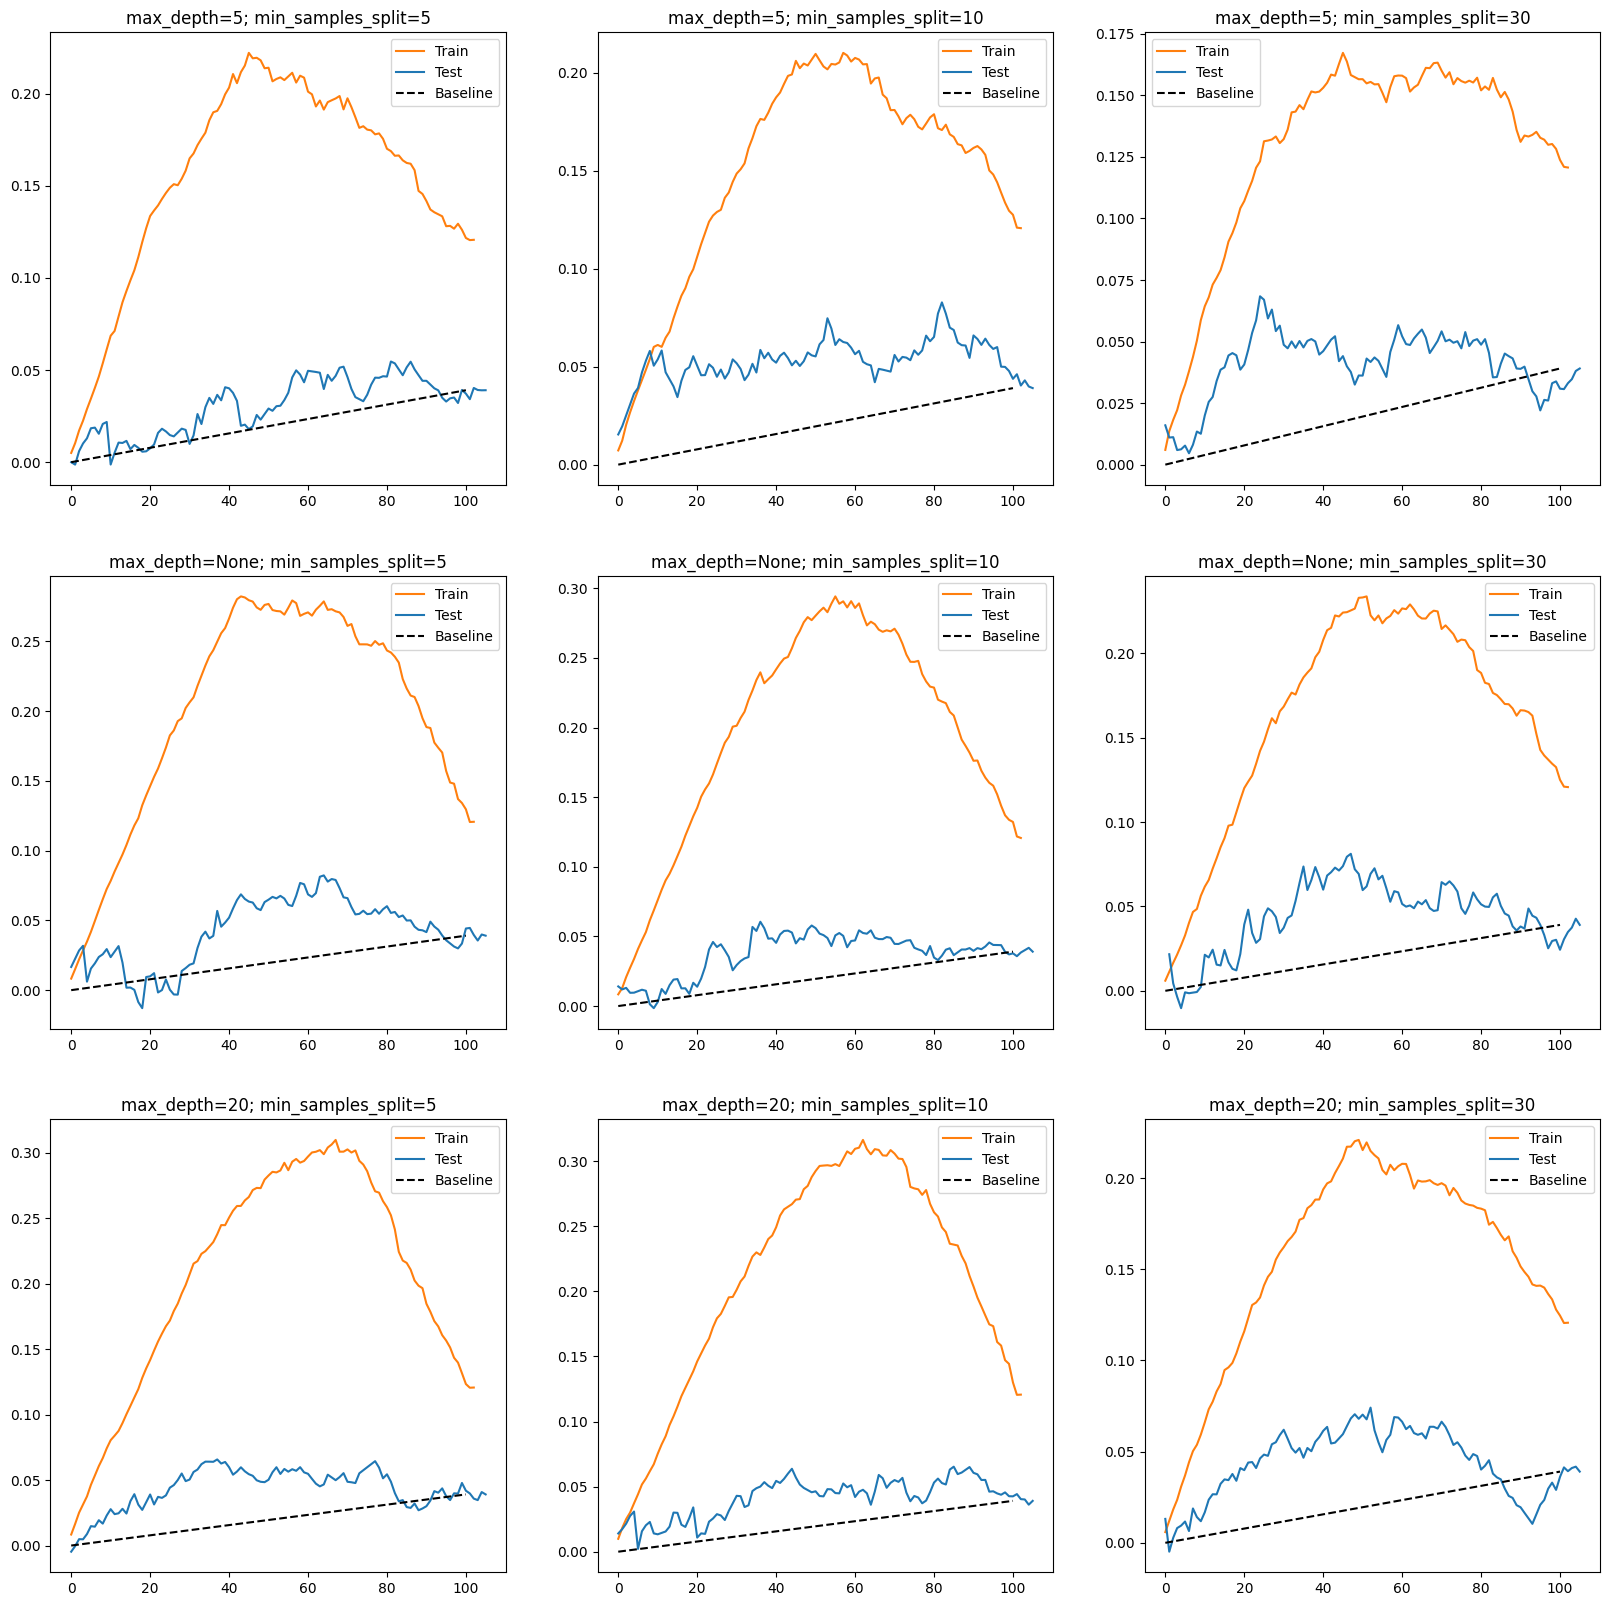

In [44]:
depths = [5, None, 20]
min_samples = [5, 10, 30]
fig, ax = plt.subplots(3, 3, figsize=(20,20))

train, test = train_test_split(full_data, test_size=0.3)

for i, dep in enumerate(depths):
    for j, m_s in enumerate(min_samples):
        cau_forest = CausalForest(max_depth=dep, min_samples_split=m_s)
        cau_forest.fit(train[columns_x], train["W"], train["Y"])

        causal_forest_cate_train = train.assign(cate=cau_forest.predict(train[columns_x]))
        causal_forest_cate_test = test.assign(cate=cau_forest.predict(test[columns_x]))

        gain_curve_train_c_f = cumulative_gain(causal_forest_cate_train, "cate", y="Y", t="W")
        gain_curve_test_c_f = cumulative_gain(causal_forest_cate_test, "cate", y="Y", t="W")

        ax[i,j].plot(gain_curve_train_c_f, color="C1", label="Train")
        ax[i,j].plot(gain_curve_test_c_f, color="C0", label="Test")
        ax[i,j].plot([0, 100], [0, elast(test, "Y", "W")], linestyle="--", color="black", label="Baseline")
        ax[i,j].legend()
        ax[i,j].set_title(f"max_depth={dep}; min_samples_split={m_s}")

In [13]:
explainer = shap.Explainer(causal_forest)
shap_values = explainer(imp_xs)
shap_values


.values =
array([[ 0.00738397, -0.00046745,  0.01039323, ..., -0.0061461 ,
         0.00297799,  0.00072448],
       [-0.00229353, -0.0003557 ,  0.01203345, ...,  0.00320834,
         0.00259485,  0.00108462],
       [-0.00623386, -0.00112504, -0.00579274, ..., -0.01695917,
         0.00379041, -0.00250628],
       ...,
       [ 0.00786221,  0.00237262,  0.01937777, ...,  0.00818234,
         0.01016412,  0.00428301],
       [ 0.00102819, -0.00178238,  0.0079671 , ...,  0.00135067,
         0.00246423, -0.00807936],
       [-0.00250356, -0.00298089, -0.00201927, ..., -0.008975  ,
        -0.00432399, -0.00145395]])

.base_values =
array([0.07339881, 0.07339881, 0.07339881, ..., 0.07339881, 0.07339881,
       0.07339881])

.data =
array([[ 0.73297099,  1.1911824 ,  0.18384149, ..., -0.41647661,
        -0.67539035,  0.46462117],
       [-1.00500405, -0.83928898,  1.4229742 , ..., -0.19910869,
        -0.76933297,  0.44798137],
       [ 1.35367636, -0.83928898, -0.38105724, ..., -1.15659

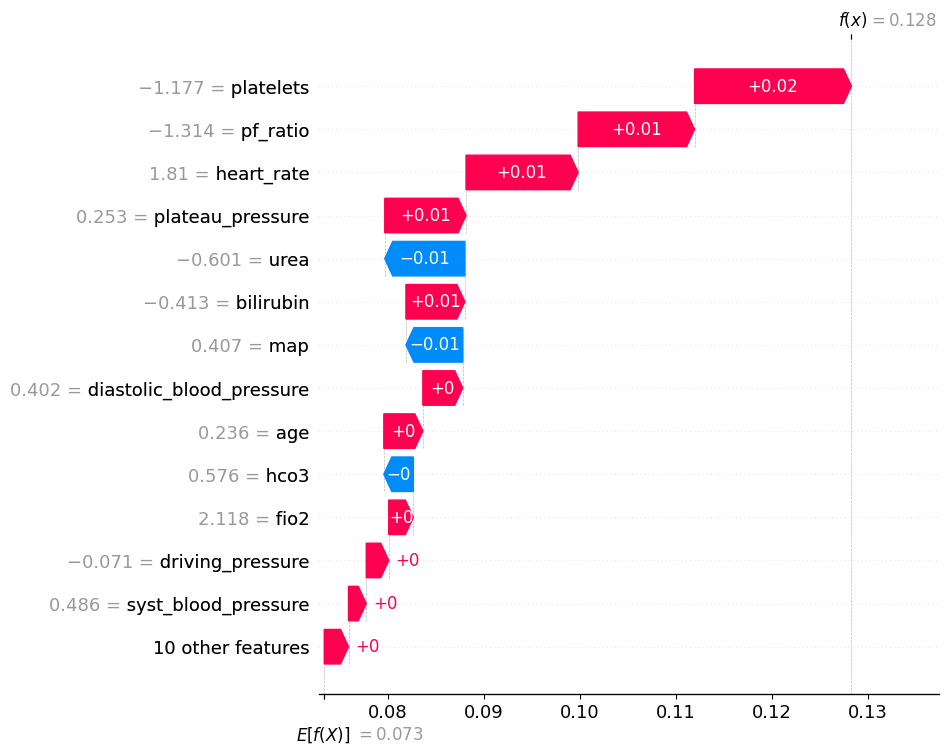

In [11]:
sample_ind = 20
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

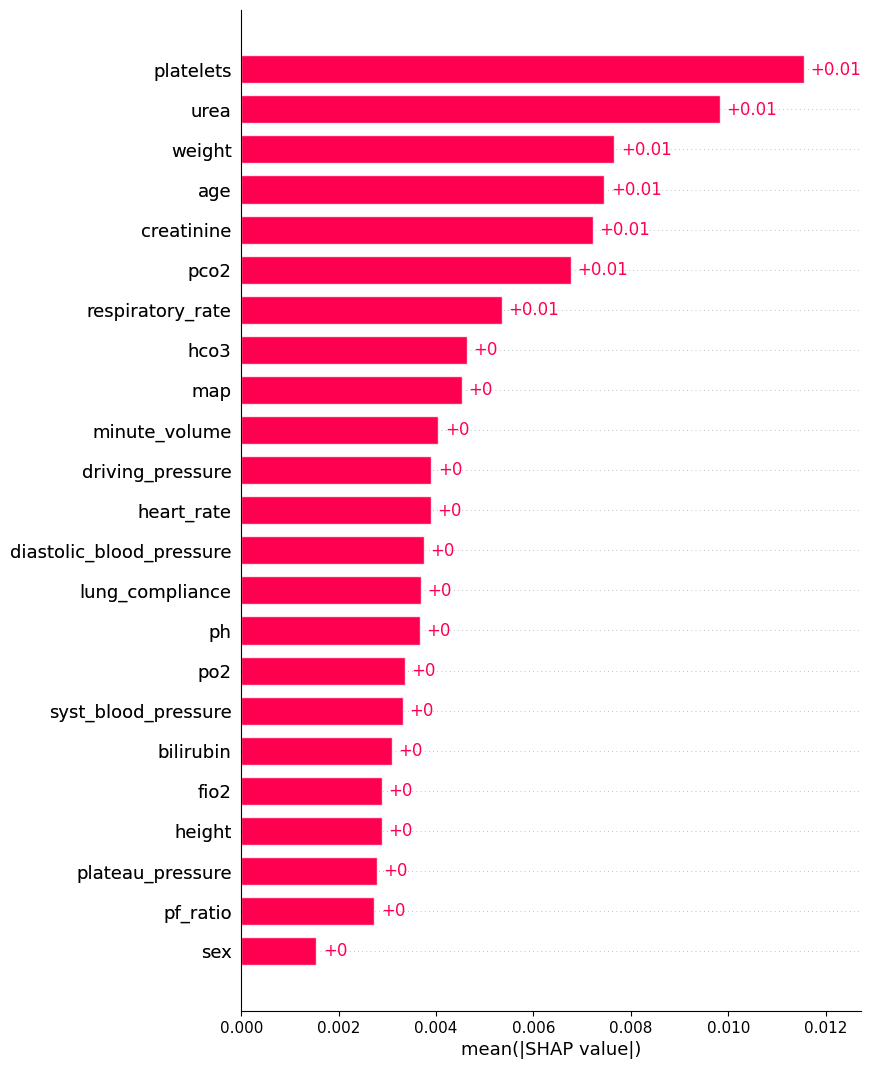

In [14]:
shap.plots.bar(shap_values, max_display=24)